In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
# from skimage.feature import draw_haar_like_feature

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
# import feature_extraction.haar_features.haar_modules as hm
# from general_utils.utils import get_an_example_array
# from general_utils.plots import draw_our_haar_like_features
# from matplotlib.ticker import StrMethodFormatter, NullFormatter
# from mc_candidate_proposal.candidate_utils import balance_candidates
# from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
import umap
import umap.plot

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

In [3]:
path = (Path.cwd().parent.parent / f'data/haar_models/')
with open(path/'final_feat_selection.p', 'rb') as f:
    selection = pickle.load(f)

In [4]:
# Candidate Proposals detector
hd = HoughCalcificationDetection(filter_muscle_region=True)

haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

In [12]:
# for idx in tqdm(range(len(db))):
#     # Get image to process
#     db_sample = db[idx]
#     image = db_sample['img']
#     image_id = db.df.iloc[idx].img_id
#     image_mask = db_sample['lesion_mask']
#     muscle_mask = db_sample['muscle_mask']

#     # Avoid reprocessing
#     path = (Path.cwd().parent.parent / f'data/haar_features_selection/{image_id}.fth')
#     path.parent.mkdir(exist_ok=True, parents=True)
#     if path.exists():
#         continue
#     else:
#         # candidate detection
#         candidates = hd.detect(
#             image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

#         # labeling of candidates:
#         tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
#             candidates, image_mask, None, 14)
#         candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

#         # Extracting features
#         labels = np.where(candidates.drop_duplicates(subset='repeted_idxs').label.values == 'TP', True, False)
        
#         # Avoid extracting features for repeted detections
#         X = candidates.drop_duplicates(subset='repeted_idxs')
#         X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

#         # Get features dfs
#         res = pd.DataFrame(data=X, columns=cfe.feature_names)
#         res['img_id'] = image_id
#         res['labels'] = labels

#         res.to_feather(path)

100%|██████████| 167/167 [19:57<00:00,  7.17s/it]


In [13]:
# # Fraction features in two dfs
# for idx in tqdm(range(len(db))):
#     # Get case
#     image_id = db.df.iloc[idx].img_id

#     # Load data
#     path = (Path.cwd().parent.parent / f'data/haar_features_selection/{image_id}.fth')
#     if path.exists():
#         data = pd.read_feather(path)

#         # # Sample fp to reduce size
#         # TPs = data.loc[data.labels]
#         # n_TPs = len(TPs)
#         # sample_size = n_TPs * 10
#         # if len(data.loc[~data.labels]) >= sample_size:
#         #     FPs = data.loc[~data.labels].sample(sample_size, random_state=0, replace=False)
#         # else:
#         #     FPs = data.loc[~data.labels]

#         # # Rejoin
#         # data = pd.concat([TPs, FPs], axis=0).sample(frac=1)
#         if idx == 0:
#             fdf = data
#         else:
#             fdf = pd.concat([fdf, data])
#         del data
#     else:
#         print(f'warining: file {image_id}.fth does not exist')
# # Store
# fdf.reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features_selection/all_cases_selected_features.fth')
# del fdf

100%|██████████| 167/167 [00:35<00:00,  4.65it/s]


In [21]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features_selection/all_cases_selected_features.fth')

In [22]:
means = np.mean(data.loc[:, data.columns[:-4]].values, axis=0)
stds = np.std(data.loc[:, data.columns[:-4]].values, axis=0)

for k, c in enumerate(data.loc[:, data.columns[:-4]].columns):
    data.loc[:, c] = (data.loc[:, c] - means[k]) / stds[k]

In [24]:
print(data.labels.value_counts())
TP = data.loc[data.labels]
FP = data.loc[~data.labels]
data = pd.concat([TP, FP.sample(len(TP)*10, random_state=0, replace=False)], ignore_index=True)
print(data.labels.value_counts())

False    160732
True       3279
Name: labels, dtype: int64
False    32790
True      3279
Name: labels, dtype: int64


In [25]:
mapper = umap.UMAP(random_state=42, n_jobs=-1, verbose=True).fit(data.loc[:, data.columns[:-4]].values)

UMAP(random_state=42, verbose=True)
Thu May 19 09:32:51 2022 Construct fuzzy simplicial set
Thu May 19 09:32:51 2022 Finding Nearest Neighbors
Thu May 19 09:32:51 2022 Building RP forest with 14 trees
Thu May 19 09:32:54 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Thu May 19 09:33:03 2022 Finished Nearest Neighbor Search
Thu May 19 09:33:20 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:33]


Thu May 19 09:34:04 2022 Finished embedding


<AxesSubplot:>

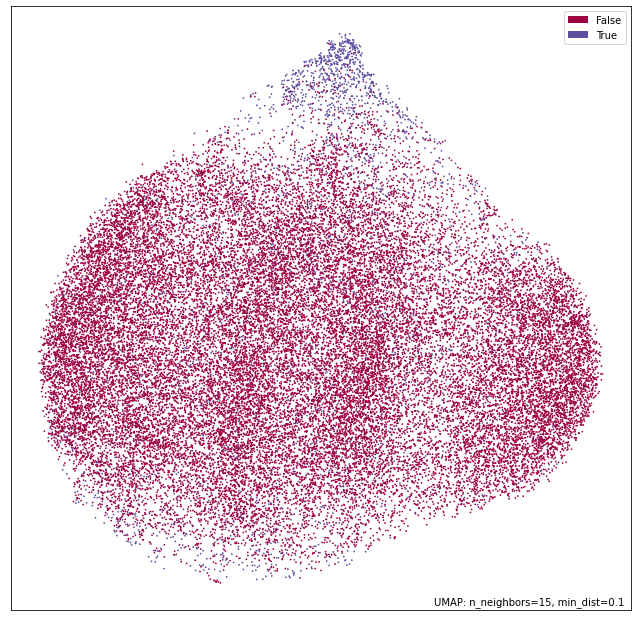

In [26]:
umap.plot.points(mapper, labels=data.labels)

In [41]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42,
        n_jobs=-1,
        verbose=True
    )
    u = fit.fit_transform(data.loc[:, data.columns[:-4]].values)
    # fig = plt.figure()
    umap.plot.points(u, labels=data.labels)
    # if n_components == 1:
    #     ax = fig.add_subplot(111)
    #     ax.scatter(u[:,0], range(len(u)), c=data.labels)
    # if n_components == 2:
    #     ax = fig.add_subplot(111)
    #     ax.scatter(u[:,0], u[:,1], c=data.labels)
    # if n_components == 3:
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(u[:,0], u[:,1], u[:,2], c=data.labels, s=100)
    # plt.title(title, fontsize=18)
    # plt.show()

In [43]:
for n in tqdm([20, 50, 100, 200], total=7):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

  0%|          | 0/7 [00:00<?, ?it/s]

UMAP(n_neighbors=20, random_state=42, verbose=True)
Thu May 19 09:52:52 2022 Construct fuzzy simplicial set
Thu May 19 09:52:52 2022 Finding Nearest Neighbors
Thu May 19 09:52:52 2022 Building RP forest with 14 trees
Thu May 19 09:52:55 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Thu May 19 09:53:17 2022 Finished Nearest Neighbor Search
Thu May 19 09:54:54 2022 Construct embedding


In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(X)